In [31]:
# Required packages
# CUDA 10.2
# torch==1.7.1
# torchvision==0.8.2
# tqdm==4.36.1
# matplotlib==2.1.0
# numpy==1.18.4

# ***EA2 : Adversarial Examples - FGSM***

## Import Packages
Import library packages for this assignment.

In [1]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from time import *
import random
import math
import csv
%matplotlib inline

## Convolutional Neural Network (CNN) Model
DLS_Model is a CNN model that classifies handwritten digits using the MNIST dataset.

In [2]:
class DLS_Model(nn.Module):
    def __init__(self):
        super(DLS_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 2)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

        x = F.relu(self.pool1((self.conv1(x))))
        x = F.relu(self.pool2((self.conv2(x))))
        x = F.relu(self.pool3((self.conv3(x))))

        #print(x.shape)
        x = x.view(-1, 128 * 3 * 3)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x


## Training and Testing of the Benign Model

Torch 2.0.0+cu118 CUDA 11.8
Model is using cuda
DLS_Model(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc2_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model Parameters 0.17361m
Only Test
Let's visualize some test samples
Accuracy of the network on the test images: 99 %


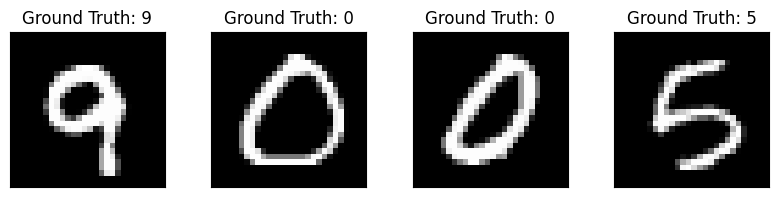

In [3]:
def training(model, trainloader, device, optimizer, num_epoch, criterion, PATH):
    model.train()
    train_loss_history = []
    train_accuracy_history = []
    
    for epoch in range(1, num_epoch + 1):
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward(retain_graph=True)
                optimizer.step()

                # Update running loss
                running_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                tepoch.set_postfix(loss=loss.item())
                #sleep(0.0001)
        
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100.0 * correct / total
        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)
    torch.save(model.state_dict(), PATH)    
    return train_loss_history, train_accuracy_history


def testing(model,testloader,device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100.0 * correct / total))

    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def show_some_image(trainloader):
    examples = enumerate(trainloader)
    batch_idx, (example_data, example_targets) = next(examples)
    fig = plt.figure(figsize=(8,10))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

# specify the GPU device
use_cuda = True
#use_cuda = False
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
print(f'Model is using {device}')


model = DLS_Model()
model = model.to(device)

BATCH_SIZE = 128
num_epoch = 75
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainloader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)

print(model)
print(f'Model Parameters {count_parameters(model)/1000000}m')   

saved_model = './mnist.pth'
if os.path.exists(saved_model):
    print(f'Only Test')
    model.load_state_dict(torch.load(saved_model))
    print(f'Let\'s visualize some test samples')
    show_some_image(testloader)
    testing(model,testloader,device)
else:
    train_loss_history, train_accuracy_history = training(model, trainloader, device, optimizer, num_epoch, criterion, saved_model)
    testing(model,testloader,device)
    print(f'Let\'s visualize some test samples')
    show_some_image(testloader)

    with open('training_loss_accuracy_benign.csv', mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Epoch', 'Loss', 'Accuracy'])

        for epoch, (loss, accuracy) in enumerate(zip(train_loss_history, train_accuracy_history), start=1):
            csv_writer.writerow([epoch, loss, accuracy])

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epoch + 1), train_loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epoch + 1), train_accuracy_history, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# ***Fast Gradient Sign Attack(FGSM)***

FGSM is an adversarial attack technique that generates a visually imperceptible adversarial example that fools the image classifier

## Load the pretrained model and dataset
Load the pretrained model and set the parameters for the attack

In [ ]:
# FGSM Attack Parameters
fgsm_epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Dataset used create perturbations
fgsm_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),]))
# MNIST Test dataset and dataloader declaration, batch size has to be 1 to attack the model
fgsm_test_loader = DataLoader(fgsm_test_dataset, batch_size=1, shuffle=True)

trainloader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)

# Select whether or not to use CUDA
#use_cuda = True
use_cuda = False
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Pretrained model
benign_model_path = './mnist.pth'
benign_model = DLS_Model().to(device)
benign_model.load_state_dict(torch.load(benign_model_path))

CUDA Available:  True


<All keys matched successfully>

## Get Random Samples
Randomly pick 10 samples from each class within the dataset

In [5]:
def random_samples(test_loader, samples_per_class=10):
    class_samples = [[] for _ in range(samples_per_class)]
    for images, labels in test_loader:
        for i, label in enumerate(labels):
            if len(class_samples[label.item()]) < samples_per_class:
                class_samples[label.item()].append((images[i].unsqueeze(0), labels))
            if all(len(samples) >= samples_per_class for samples in class_samples):
                break
    return [sample for class_samples in class_samples for sample in class_samples]

## Show Attack Samples
Show the perturbated 10 samples for each epsilon within the dataset

In [6]:
def showExamples(epsilons, examples, picked_class, title):
    adversarial_images, initial_predictions, final_predictions = [], [], []
    for count in range(len(epsilons)):
        if examples[count][picked_class]:
            # Pick the perturbed samples belonging to the picked class
            picked_example = random.choice(examples[count][picked_class])
            original_prediction, final_prediction, image = picked_example
            initial_predictions.append(original_prediction)
            final_predictions.append(final_prediction)
            adversarial_images.append(image)
        else:
            print("No examples available for the selected class.")

    # Plot the perturbed images
    num_images = len(adversarial_images)
    num_cols = 5
    num_rows = math.ceil(num_images / num_cols)
    fig = plt.figure(figsize=(15, 3 * num_rows))
    plt.suptitle(title, fontsize=16, y=0.78)
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.tight_layout()
        plt.imshow(adversarial_images[i], cmap='gray', interpolation='none')
        plt.title("Epsilon: {} \nGround Truth: {}\nAttack: {}".format(epsilons[i], initial_predictions[i], final_predictions[i]))
        plt.xticks([])
        plt.yticks([])

## FGSM Attack
Attack function for FGSM that uses the image, epsilon value and gradient to create perturbed image

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

Attack test function that conducts the FGSM attack on a model

In [8]:
# FGSM Attack adapted from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_test(model, device, test_loader, epsilons):
    # Set the model to evaluation mode to correctly attack the model
    model.eval()
    # Initialize variables to track correct predictions and adversarial examples
    correct_predictions = 0
    adversarial_examples = [[] for _ in range(10)]

    # Loop through the input data
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor to True for the attack
        images.requires_grad = True

        # Forward pass the data through the model
        model = model.to(device)
        output = model(images)
        
        # If the initial prediction is wrong, don't bother attacking
        initial_prediction = output.max(1, keepdim=True)[1]
        if initial_prediction.item() != labels.item():
            continue

        # Zero all existing gradients
        model.zero_grad()

        # Calculate the loss and gradients in backward pass
        loss = F.nll_loss(output, labels)
        loss.backward()
        image_gradients = images.grad.data

        # Call the FGSM attack
        perturbed_images = fgsm_attack(images, epsilons, image_gradients)
        
        # Re-classify the perturbed image
        output = model(perturbed_images)
        
        # Count the number of successful predictions
        final_prediction = output.max(1, keepdim=True)[1]
        if final_prediction.item() == labels.item():
            correct_predictions += 1
                
        # Save the adversarial examples
        adversarial_examples[labels.item()].append((initial_prediction.item(), final_prediction.item(), perturbed_images.squeeze().detach().cpu().numpy()))

    # Calculate the final accuracy and average loss
    accuracy = correct_predictions / float(len(test_loader))
    print("Epsilon: {}\tAccuracy = {}\t".format(epsilons, accuracy))
    return accuracy, adversarial_examples


Iterates the FGSM attack on each of the epsilon values and gathers examples

In [9]:
fgsm_accuracies = []
fgsm_losses = []
fgsm_examples = []
labels_list = set()
# Get the randomly picked samples from test_loader
test_samples = random_samples(fgsm_test_loader)
for images, labels in test_samples:
    images, labels = images.to(device), labels.to(device)
    labels_list.add(labels.item())

# Run test for each epsilon
for eps in fgsm_epsilons:
    accuracy, adversarial_examples = fgsm_test(model, device, test_samples, eps)
    fgsm_accuracies.append(accuracy)
    fgsm_examples.append(adversarial_examples)

Epsilon: 0	Accuracy = 0.99	
Epsilon: 0.1	Accuracy = 0.77	
Epsilon: 0.2	Accuracy = 0.31	
Epsilon: 0.3	Accuracy = 0.17	
Epsilon: 0.4	Accuracy = 0.11	
Epsilon: 0.5	Accuracy = 0.1	
Epsilon: 0.6	Accuracy = 0.1	
Epsilon: 0.7	Accuracy = 0.1	
Epsilon: 0.8	Accuracy = 0.1	
Epsilon: 0.9	Accuracy = 0.1	


Plot the Accuracy vs Epsilon for the FGSM attack on the benign model

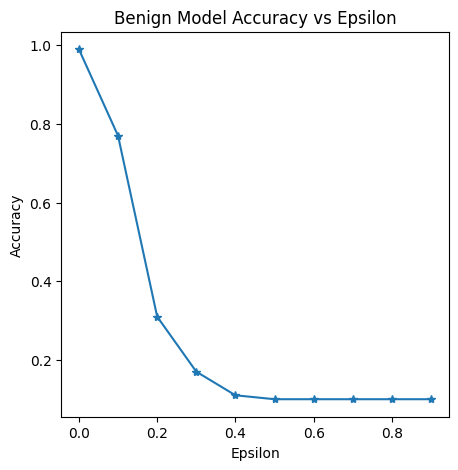

In [10]:
# Plot the accuracy vs. epsilon
plt.figure(figsize=(5,5))
plt.plot(fgsm_epsilons, fgsm_accuracies, "*-")
plt.title("Benign Model Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Show the perturbed images created by the adversarial attacks



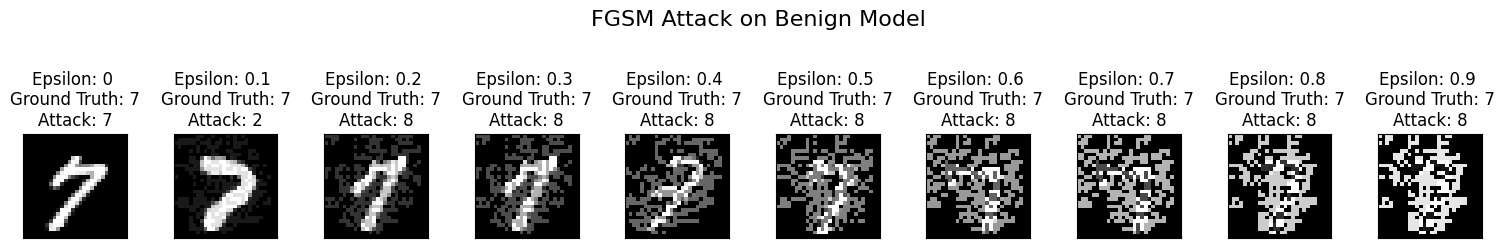

In [11]:
picked_class = random.choice(list(labels_list))
showExamples(fgsm_epsilons, fgsm_examples, picked_class, "FGSM Attack on Benign Model")

# ***Adversarial Training on FGSM***
Training the models on the perturbed images to make them resilient to FGSM attacks

Set the parameters to generate adversarial examples to use for adversarial training

In [12]:
# Training perturbation epsilons
fgsm_training_eps = [0.05, 0.1, 0.2, 0.25, 0.3]
training_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])), batch_size=1, shuffle=True)

# Dataset used create perturbations
fgsm_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),]))
# MNIST Test dataset and dataloader declaration, batch size has to be 1 to attack the model
fgsm_test_loader = DataLoader(fgsm_test_dataset, batch_size=1, shuffle=True)

trainloader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])),batch_size=BATCH_SIZE, shuffle=True)

## Create the Adversarial and Combined Datasets

Create adversarial dataset that consists of images perturbed by epsilon value from the data_loader 

In [13]:
# Function to create the adversarial dataset from the model and data_loader
def create_adv_dataset(model, data_loader, epsilons):
    adv_ex = []
    for ep in epsilons:
        print("Training with Epsilon: ", ep)
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True
            output = model(images)
            model.zero_grad()
            loss = F.nll_loss(output, labels)
            loss.backward()
            gradient = images.grad.data
            perturbed_images = fgsm_attack(images, ep, gradient)
            adv_ex.append((perturbed_images, labels))
    return adv_ex

Combine the benign and adversarial dataset

In [14]:
if os.path.exists('./combined_dataset.pth'):
    print('Loading Combined Dataset from file...')
    combined_dataset = torch.load('./combined_dataset.pth')
else:
    if os.path.exists('./adversarial_dataset.pth'):
        print('Loading Adversarial Dataset from file...')
        adversarial_dataset = torch.load('./adversarial_dataset.pth')
    else:
        print('Creating Adversarial Dataset...')
        # Takes 10 Minutes to run
        adversarial_dataset = create_adv_dataset(model, training_loader, fgsm_training_eps)
        torch.save(adversarial_dataset, './adversarial_dataset.pth')
    # Takes 10 Minutes to run
    combined_adv_images = []
    combined_adv_labels = []

    # Combine the adversarial and benign datasets into one
    for images, labels in adversarial_dataset:
        images, labels = images.to(device), labels.to(device)
        combined_adv_images.append(images)
        combined_adv_labels.extend(labels.tolist())
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        combined_adv_images.append(images)
        combined_adv_labels.extend(labels.tolist())

    combined_adv_images = torch.cat(combined_adv_images, dim=0)
    combined_adv_labels = torch.tensor(combined_adv_labels)
    combined_dataset = list(zip(combined_adv_images, combined_adv_labels))
    torch.save(combined_dataset, './combined_dataset.pth')
    print("Adversarial Dataset: ", len(adversarial_dataset))
print("Combined Dataset: ", len(combined_dataset))

Loading Combined Dataset from file...
Combined Dataset:  360000


## Train the existing Model on the Combined dataset

No FGSM Retrained Model found, Training...


Epoch 75: 100%|██████████| 2813/2813 [02:06<00:00, 22.32batch/s, loss=0.0114]  


Accuracy of the network on the test images: 99 %


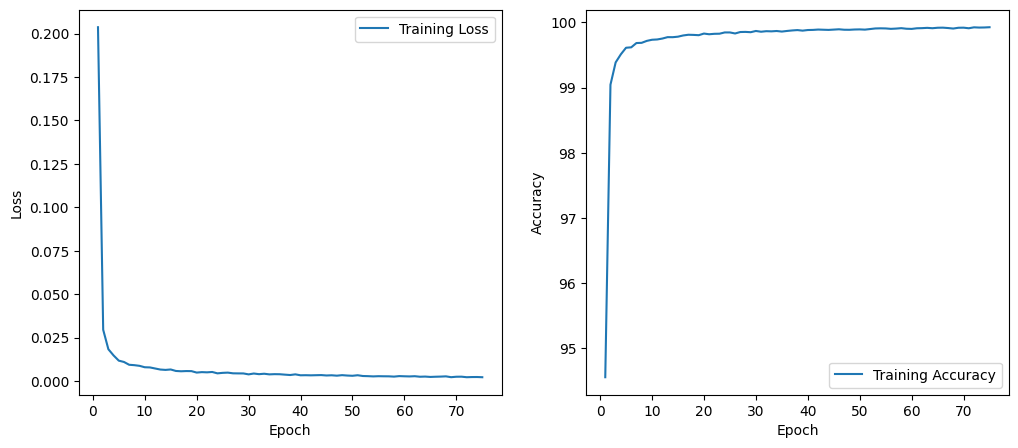

In [16]:
# Pretrained model
benign_model_path = './mnist.pth'
fgsm_retrained_model = DLS_Model().to(device)
fgsm_retrained_model.load_state_dict(torch.load(benign_model_path))

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(fgsm_retrained_model.parameters(), lr=learning_rate)
fgsm_trainloader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

# The retrained model is trained and saved as fgsm_retrained_model.pth in the folder
fgsm_retrained_model_path = './fgsm_retrained_model.pth'
if os.path.exists(fgsm_retrained_model_path):
    print(f'Found the FGSM Trained Model, Testing...')
    fgsm_retrained_model.load_state_dict(torch.load(fgsm_retrained_model_path))
    testing(fgsm_retrained_model,testloader,device)
else:
    print(f'No FGSM Retrained Model found, Training...')
    train_loss_history, train_accuracy_history = training(fgsm_retrained_model, fgsm_trainloader, device, optimizer, num_epoch, criterion, PATH='./fgsm_retrained_model.pth')
    testing(fgsm_retrained_model,testloader,device)
    with open('retrained_adv_model_training.csv', mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Epoch', 'Loss', 'Accuracy'])
        for epoch, (loss, accuracy) in enumerate(zip(train_loss_history, train_accuracy_history), start=1):
            csv_writer.writerow([epoch, loss, accuracy])
            
    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epoch + 1), train_loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epoch + 1), train_accuracy_history, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


## Train a new Model on the Combined dataset

DLS_Model(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc2_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model Parameters 0.17361m
No FGSM Trained Model found, Training...


Epoch 75: 100%|██████████| 2813/2813 [02:08<00:00, 21.88batch/s, loss=2.38e-5] 


Accuracy of the network on the test images: 99 %


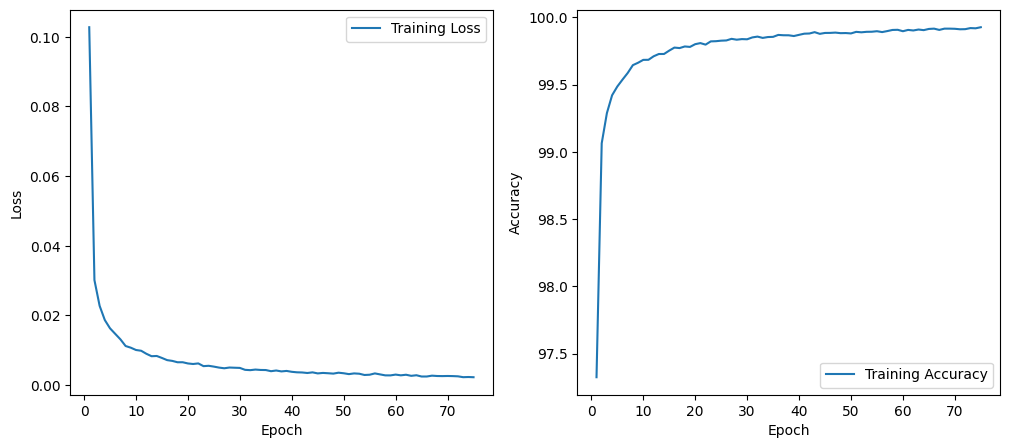

In [17]:
fgsm_trained_model = DLS_Model()
fgsm_trained_model = fgsm_trained_model.to(device)

num_epoch = 75

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(fgsm_trained_model.parameters(), lr=learning_rate)

fgsm_trainloader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(fgsm_trained_model)
print(f'Model Parameters {count_parameters(fgsm_trained_model)/1000000}m')   

# The untrained model is trained and saved as fgsm_trained_model.pth in the folder
fgsm_trained_model_path = './fgsm_trained_model.pth'
if os.path.exists(fgsm_trained_model_path):
    print(f'Found the FGSM Trained Model, Testing...')
    fgsm_trained_model.load_state_dict(torch.load(fgsm_trained_model_path))
    testing(fgsm_trained_model,testloader,device)
else:
    print(f'No FGSM Trained Model found, Training...')
    train_loss_history, train_accuracy_history = training(fgsm_trained_model, fgsm_trainloader, device, optimizer, num_epoch, criterion, PATH='./fgsm_trained_model.pth')
    testing(fgsm_trained_model,testloader,device)
    with open('new_adv_model_training.csv', mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Epoch', 'Loss', 'Accuracy'])
        for epoch, (loss, accuracy) in enumerate(zip(train_loss_history, train_accuracy_history), start=1):
            csv_writer.writerow([epoch, loss, accuracy])
            
    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epoch + 1), train_loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epoch + 1), train_accuracy_history, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# ***Adversarial Attack on Benign and Trained Model***

## Compare the Models
Function to compare three models based on the epsilon given, then show the accuracy vs epsilon graph for each

In [18]:
def compare_models(epsilons, model_1, model_2, model_3, title_1, title_2, title_3):
    accuracies_1 = []
    examples_1 = []
    accuracies_2 = []
    examples_2 = []
    accuracies_3 = []
    examples_3 = []

    test_samples = random_samples(fgsm_test_loader)
    print("Testing on " + title_1)
    for eps in epsilons:
        accuracy_1, adversarial_examples_1 = fgsm_test(model_1, device, test_samples, eps)
        accuracies_1.append(accuracy_1)
        examples_1.append(adversarial_examples_1)

    # Write the accuracy vs. epsilon to file
    with open('accuracy_vs_epsilon_1.csv', mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Accuracy', 'Epsilon'])
        count = 0
        for ep in epsilons:
            csv_writer.writerow([ep, accuracies_1[count]])
            count +=1

    print("Testing on " + title_2)
    for eps in epsilons:
        accuracy_2, adversarial_examples_2 = fgsm_test(model_2, device, test_samples, eps)
        accuracies_2.append(accuracy_2)
        examples_2.append(adversarial_examples_2)

    # Write the accuracy vs. epsilon to file
    with open('accuracy_vs_epsilon_2.csv', mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Accuracy', 'Epsilon'])
        count = 0
        for ep in epsilons:
            csv_writer.writerow([ep, accuracies_2[count]])
            count +=1

    print("Testing on " + title_3)
    for eps in epsilons:
        accuracy_3, adversarial_examples_3 = fgsm_test(model_3, device, test_samples, eps)
        accuracies_3.append(accuracy_3)
        examples_3.append(adversarial_examples_3)

    # Write the accuracy vs. epsilon to file
    with open('accuracy_vs_epsilon_3.csv', mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Accuracy', 'Epsilon'])
        count = 0
        for ep in epsilons:
            csv_writer.writerow([ep, accuracies_3[count]])
            count +=1

    # Plot the accuracy vs. epsilon
    plt.figure(figsize=(12, 5))
    plt.plot(epsilons, accuracies_1, "*-", label=title_1)
    plt.plot(epsilons, accuracies_2, "*-", label=title_2)
    plt.plot(epsilons, accuracies_3, "*-", label=title_3)
    plt.legend()
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Epsilon of the models")

    return examples_1, examples_2, examples_3

Compare the Benign Model, the original FGSM model (retrained) and the untrained FGSM model against FGSM attacks

Testing on Baseline Model
Epsilon: 0	Accuracy = 0.99	
Epsilon: 0.05	Accuracy = 0.92	
Epsilon: 0.1	Accuracy = 0.82	
Epsilon: 0.15	Accuracy = 0.46	
Epsilon: 0.2	Accuracy = 0.26	
Epsilon: 0.25	Accuracy = 0.14	
Epsilon: 0.3	Accuracy = 0.11	
Epsilon: 0.35	Accuracy = 0.08	
Epsilon: 0.4	Accuracy = 0.1	
Testing on FGSM Retrained Model
Epsilon: 0	Accuracy = 0.97	
Epsilon: 0.05	Accuracy = 0.95	
Epsilon: 0.1	Accuracy = 0.86	
Epsilon: 0.15	Accuracy = 0.71	
Epsilon: 0.2	Accuracy = 0.51	
Epsilon: 0.25	Accuracy = 0.28	
Epsilon: 0.3	Accuracy = 0.17	
Epsilon: 0.35	Accuracy = 0.11	
Epsilon: 0.4	Accuracy = 0.03	
Testing on FGSM Untrained Model
Epsilon: 0	Accuracy = 1.0	
Epsilon: 0.05	Accuracy = 0.87	
Epsilon: 0.1	Accuracy = 0.64	
Epsilon: 0.15	Accuracy = 0.29	
Epsilon: 0.2	Accuracy = 0.19	
Epsilon: 0.25	Accuracy = 0.11	
Epsilon: 0.3	Accuracy = 0.09	
Epsilon: 0.35	Accuracy = 0.05	
Epsilon: 0.4	Accuracy = 0.05	


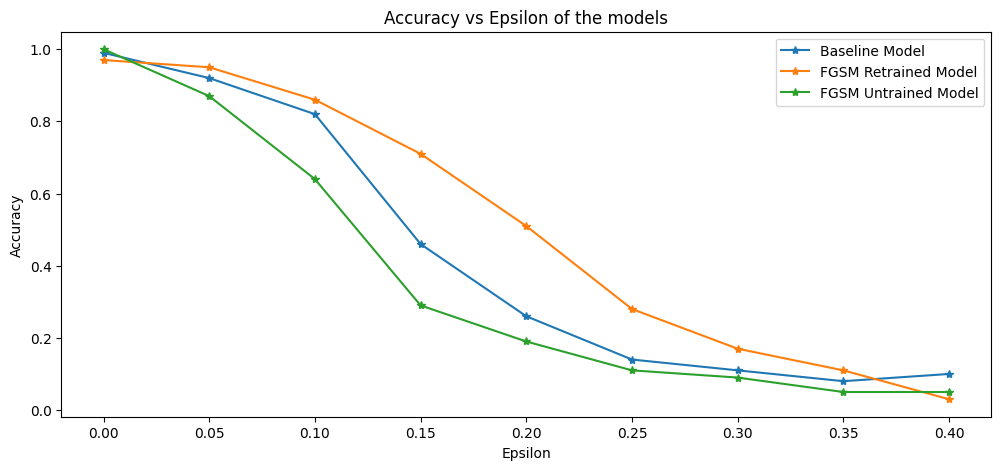

In [19]:
testing_eps = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
examples_benign, examples_retrained, examples_trained = compare_models(testing_eps, benign_model, fgsm_retrained_model, fgsm_trained_model, 'Baseline Model', 'FGSM Retrained Model', 'FGSM Untrained Model')

Compare the Benign Model, the retrained FGSM trained model, and the PGD trained model against FGSM attacks

PGD Model not found
Testing on Baseline Model
Epsilon: 0	Accuracy = 0.99	
Epsilon: 0.05	Accuracy = 0.96	
Epsilon: 0.1	Accuracy = 0.76	
Epsilon: 0.15	Accuracy = 0.44	
Epsilon: 0.2	Accuracy = 0.23	
Epsilon: 0.25	Accuracy = 0.15	
Epsilon: 0.3	Accuracy = 0.13	
Epsilon: 0.35	Accuracy = 0.11	
Epsilon: 0.4	Accuracy = 0.1	
Testing on FGSM Retrained Model
Epsilon: 0	Accuracy = 1.0	
Epsilon: 0.05	Accuracy = 0.98	
Epsilon: 0.1	Accuracy = 0.88	
Epsilon: 0.15	Accuracy = 0.7	
Epsilon: 0.2	Accuracy = 0.47	
Epsilon: 0.25	Accuracy = 0.26	
Epsilon: 0.3	Accuracy = 0.14	
Epsilon: 0.35	Accuracy = 0.09	
Epsilon: 0.4	Accuracy = 0.06	
Testing on PGD Trained Model
Epsilon: 0	Accuracy = 0.1	
Epsilon: 0.05	Accuracy = 0.1	
Epsilon: 0.1	Accuracy = 0.1	
Epsilon: 0.15	Accuracy = 0.1	
Epsilon: 0.2	Accuracy = 0.1	
Epsilon: 0.25	Accuracy = 0.1	
Epsilon: 0.3	Accuracy = 0.1	
Epsilon: 0.35	Accuracy = 0.1	
Epsilon: 0.4	Accuracy = 0.1	


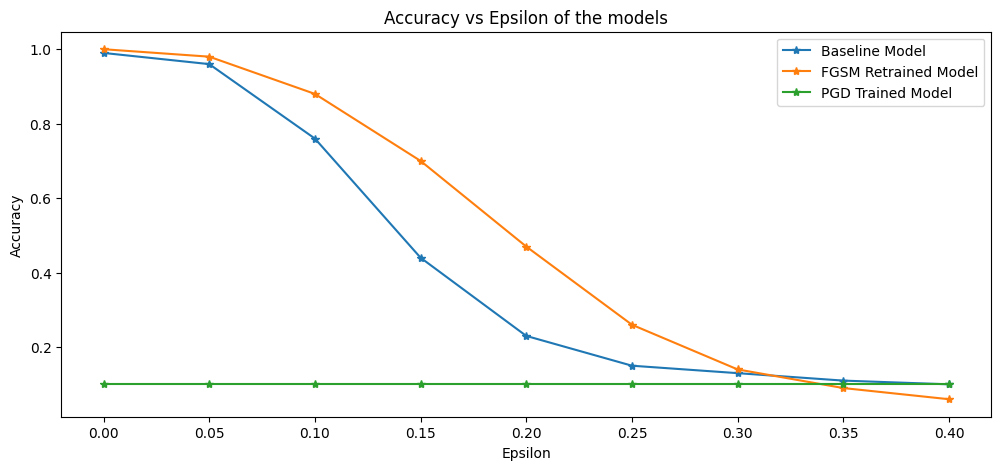

In [20]:
testing_eps = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

# Load the pgd model (should be named model_large.pth and present in the directory)
pgd_trained_model = DLS_Model()
pgd_trained_model = pgd_trained_model.to(device)
pgd_trained_model_path = './model_large.pth'
if os.path.exists(pgd_trained_model_path):
    pgd_trained_model.load_state_dict(torch.load(pgd_trained_model_path))
else:
    print("PGD Model not found")
examples_benign, examples_trained, examples_pgd = compare_models(testing_eps, benign_model, fgsm_retrained_model, pgd_trained_model, 'Baseline Model', 'FGSM Retrained Model', 'PGD Trained Model')

Chosen Class:  3


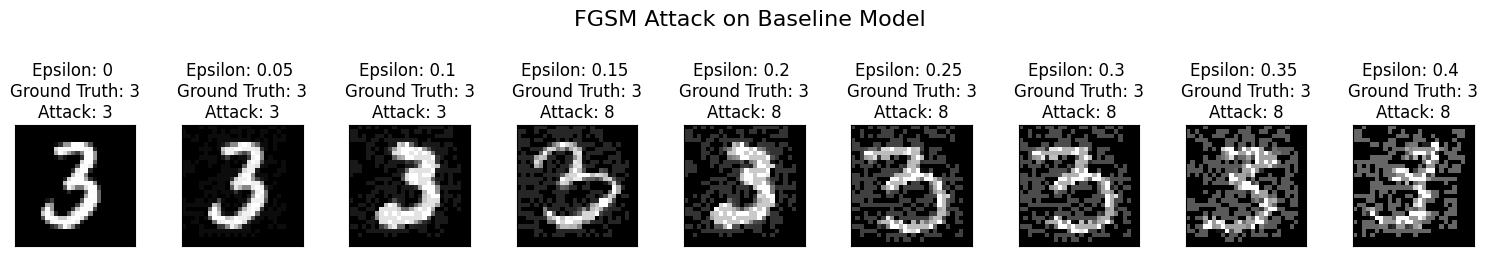

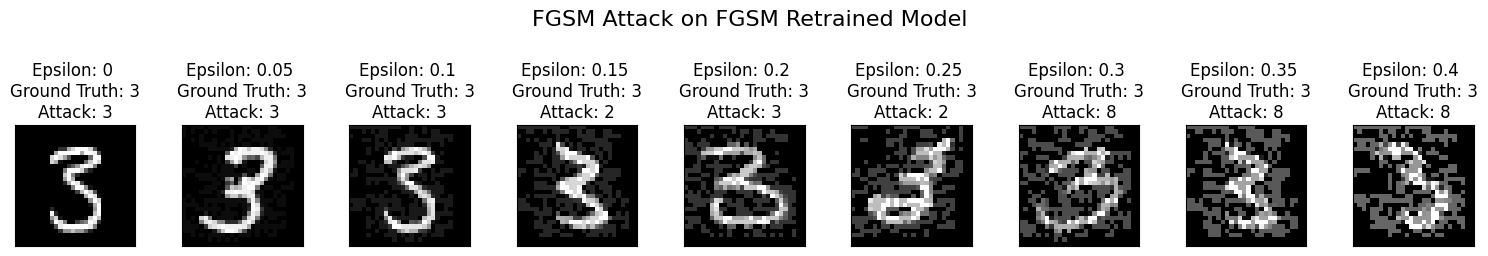

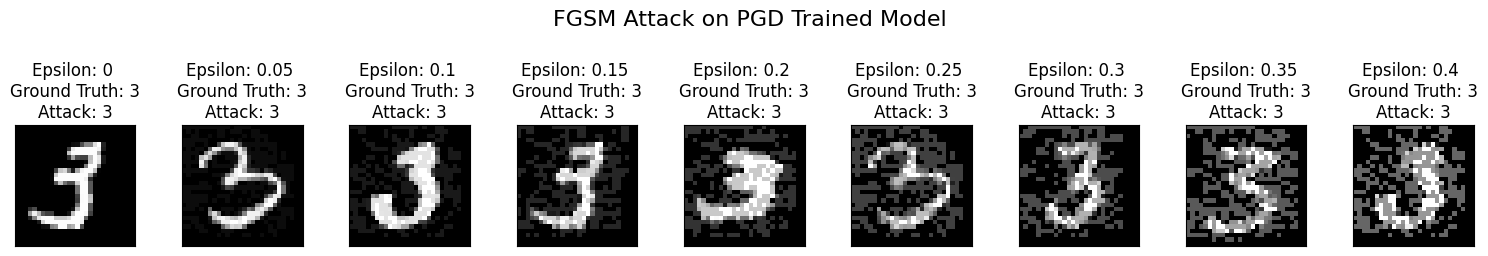

In [21]:
# Show 10 samples of the perturbed images and how they are classified by each model.
picked_class = random.choice(list(labels_list))
print("Chosen Class: ", picked_class)
showExamples(testing_eps, examples_benign, picked_class, "FGSM Attack on Baseline Model")
showExamples(testing_eps, examples_retrained, picked_class, "FGSM Attack on FGSM Retrained Model")
showExamples(testing_eps, examples_pgd, picked_class, "FGSM Attack on PGD Trained Model")